In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from collections import Counter
from itertools import product

from imblearn.over_sampling import SMOTE 

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

C:\Users\JYM\AppData\Local\Temp/ipykernel_2724/2270551363.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_2724/2270551363.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# some cleaning just ot make sure
train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

In [5]:
%%time
X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

Wall time: 58.1 s


### Grid Search Model

In [6]:
%%time
# # Define the parameters for exploration
# # First Run
# param_grid = {
#     'sample_size': [100000, 200000, 300000, 400000], 
#     'chi2_features': [5000, 10000, 20000, 25000, 30000], 
#     'clf__alpha': [0.01, 0.1, 0.5, 1.0],
#     'clf__fit_prior': [True, False], 
#     'clf__class_prior': [None]
# }

# # SECOND RUN
# param_grid = {
#     'sample_size': [100000, 200000, 300000, 400000], 
#     'chi2_features':  [20000, 25000, 30000], 
#     'clf__alpha': [0.001, 0.01, 0.1],
#     'clf__fit_prior': [True], 
#     'clf__class_prior': [None]
# }

# THIRD RUN
param_grid = {
    'sample_size': [100000, 125000, 150000], 
    'chi2_features':  [25000, 27500, 30000], 
    'clf__alpha': [0.001],
    'clf__fit_prior': [True], 
    'clf__class_prior': [None]
}

def grid_search_model(param_grid, train_df, X_dev, y_dev):
    best_params = None
    best_score = 0
    prev_score = 0
    
    for sample_size in param_grid['sample_size']:
        for chi2_features in param_grid['chi2_features']:
            # Sample and transform the train data
            train_df_sample = train_df.sample(sample_size)
            
            X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
            y_train = train_df_sample['debt_collection']
            
            selector = SelectKBest(chi2, k=chi2_features)
            X_train = selector.fit_transform(X_train, y_train)
            # Transform dev set with the same selector
            X_dev_transformed = selector.transform(X_dev)
            
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
#             oversample = RandomOverSampler(sampling_strategy='minority')
#             X_train, y_train = oversample.fit_resample(X_train, y_train)
            
            # Shuffle your data
            X_train, y_train = shuffle(X_train, y_train)
            
            for params in product(
                param_grid['clf__alpha'],
                param_grid['clf__fit_prior'],
                param_grid['clf__class_prior']
            ):
                
                # Apply the parameters
                alpha, fit_prior, class_prior = params
                
                clf = naive_bayes.MultinomialNB(
                    alpha=alpha, 
                    fit_prior=fit_prior, 
                    class_prior=class_prior
                )
                # Train and score the model
                clf.fit(X_train, y_train)
                predicted = clf.predict(X_dev_transformed)
                score = f1_score(y_dev, predicted)
                
                if score > best_score:
                    best_score = score
                    best_params = {
                        'sample_size': sample_size,
                        'chi2_features': chi2_features,
                        'clf__alpha': alpha,
                        'clf__fit_prior': fit_prior,
                        'clf__class_prior': class_prior
                    }
                    print(f"New best score:{score} using {best_params}")
#                 else:
#                     print(f"Current score:{score} using sample size={sample_size}, feature size={chi2_features} with params={params}")

                prev_score = score
                    
    return best_params

best_params = grid_search_model(param_grid, train_df, X_dev, y_dev)
print(f'Best parameters: {best_params}')

New best score:0.7344056377065857 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}
New best score:0.7347502873186983 using {'sample_size': 150000, 'chi2_features': 27500, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}
Best parameters: {'sample_size': 150000, 'chi2_features': 27500, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}
Wall time: 5min 32s


### NAIVE BAYES

In [7]:
%%time
sample_size = best_params['sample_size']
chi2_features = best_params['chi2_features']
alpha =  best_params['clf__alpha']
fit_prior =  best_params['clf__fit_prior']
class_prior =  best_params['clf__class_prior']


train_df_sample = train_df.sample(sample_size).copy()
            
X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train = train_df_sample['debt_collection']

selector = SelectKBest(chi2, k=chi2_features)
X_train = selector.fit_transform(X_train, y_train)
# Transform dev set with the same selector
X_dev_transformed = selector.transform(X_dev)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = naive_bayes.MultinomialNB(
                    alpha=alpha, 
                    fit_prior=fit_prior, 
                    class_prior=class_prior
                )
clf.fit(X_train, y_train)

Wall time: 51.3 s


MultinomialNB(alpha=0.001)

Train
accuracy_score 0.8967991572464649
balanced_accuracy_score 0.8967991572464649
average_precision_score 0.8530901533799131
              precision    recall  f1-score   support

           0       0.90      0.89      0.90    123405
           1       0.89      0.91      0.90    123405

    accuracy                           0.90    246810
   macro avg       0.90      0.90      0.90    246810
weighted avg       0.90      0.90      0.90    246810

Prediction [(1, 125606), (0, 121204)]
Ground Truth [(1, 123405), (0, 123405)]


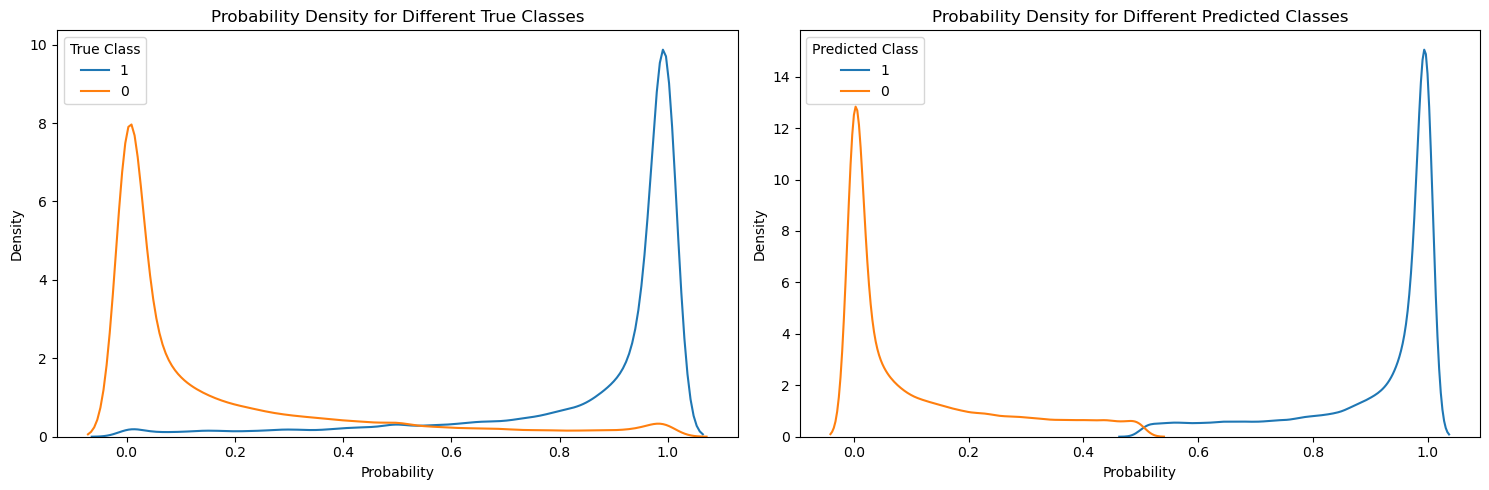

In [8]:
# get the results
y_pred = clf.predict(X_train.toarray())
y_pred_proba = clf.predict_proba(X_train.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train, y_pred))
print("average_precision_score",average_precision_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8833958837772397
balanced_accuracy_score 0.8808454407046011
average_precision_score 0.5654293975993407
              precision    recall  f1-score   support

           0       0.97      0.88      0.93    136036
           1       0.62      0.88      0.73     29164

    accuracy                           0.88    165200
   macro avg       0.80      0.88      0.83    165200
weighted avg       0.91      0.88      0.89    165200

Prediction [(0, 123953), (1, 41247)]
Ground Truth [(0, 136036), (1, 29164)]


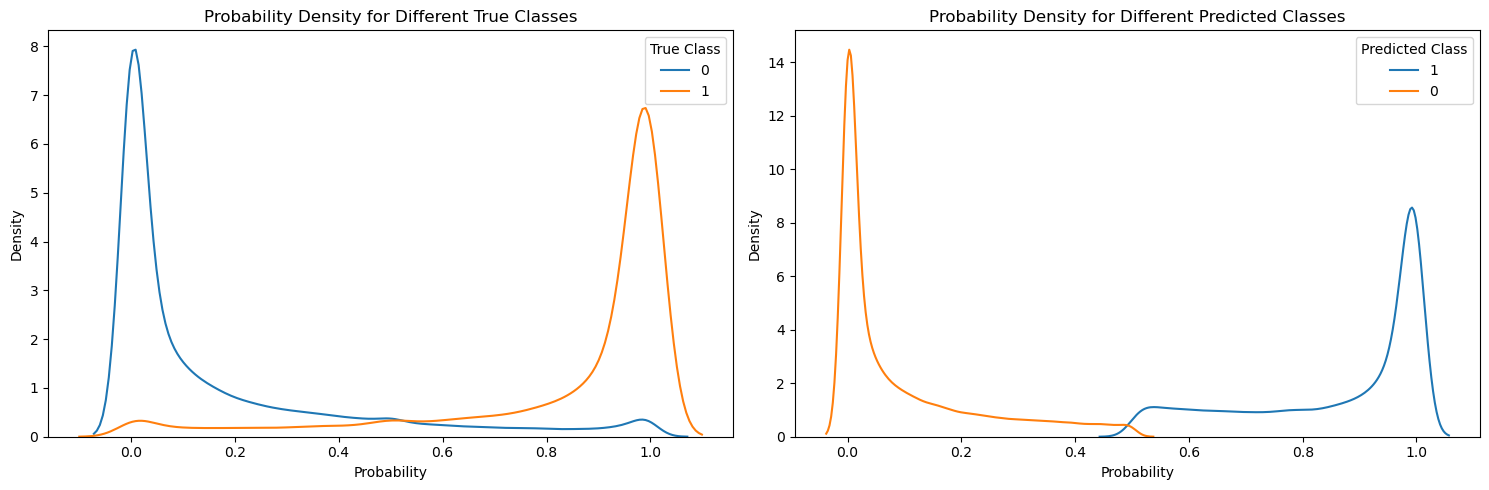

In [9]:
# get the results
y_pred = clf.predict(X_dev_transformed.toarray())
y_pred_proba = clf.predict_proba(X_dev_transformed.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Naive Bayes - Parameter Combinations that will Yield Similar Good Results

New best score:0.7256143979546401 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}

New best score:0.726597795746885 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}

New best score:0.7281897137241867 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}

New best score:0.728453501125671 using {'sample_size': 100000, 'chi2_features': 27500, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}

Best parameters: {'sample_size': 100000, 'chi2_features': 27500, 'clf__alpha': 0.001, 'clf__fit_prior': True, 'clf__class_prior': None}

It requires 100,000 samples and about 27500 features to yield acceptable results.So far the most economical one.